# 손글씨 데이터셋 (MNIST)을 활용한 분류모델

In [21]:
# 기본 라이브러리 불러오기
import numpy as np                          # 수치 연산
import pandas as pd                         # DataFrame 처리
import matplotlib.pyplot as plt             # 시각화(그래프)
import seaborn as sns                       # 시각화(차트)

# torch 계열 라이브러리 
import torch                                # Pytorch 핵심 패키지
import torch.nn as nn                       # 신경망 레이어/모듈
import torch.nn.functional as F             # 활성화/손실 함수 등 함수 API
import torch.optim as optim                 # 최적화함수 Oprimizer

# 데이터셋 및 전처리
from torchvision import datasets, transforms    # 기본 데이터셋 로딩, 데이터셋 전처리

# 검증
from sklearn.metrics import confusion_matrix    # 혼동행렬


# NMIST (손글씨 숫자 이미지) 데이터 셋 다운로드 및 전처리

In [22]:
# 학습용 (MNIST train) 데이터셋
train = datasets.MNIST(                 # MNIST 학습 데이터셋 객체 생성
    './data',                           # 데이터 저장 경로
    train=True,                         # 학습(train) 데이터셋 사용
    download=True,                      # 없으면 인터넷에서 다운로드
    transform=transforms.Compose([      # 전처리를 순서대로 적용(전처리 파이프라인)
        transforms.ToTensor(),          # PIL/ndarray -> torch.Tensor(0~1스케일)
    ])
)

# 테스트용 (MNIST train) 데이터셋
test = datasets.MNIST(
    './data',
    train=False,                        # 테스트(Test) 데이터셋 사용
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ])
)

train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [23]:
img, label = train[0]   # 0번째 샘플에서 (이미지 텐서, 정답 라벨) 추출
img.shape               # 이미지 텐서 모양 확인(1, 28, 28)

torch.Size([1, 28, 28])

Pytorch(NMIST) / Conv : channel-first(C, H, W)  
Numpy / OpenCV / matplotlib / Tensorflow : channel-last(H, W, C)

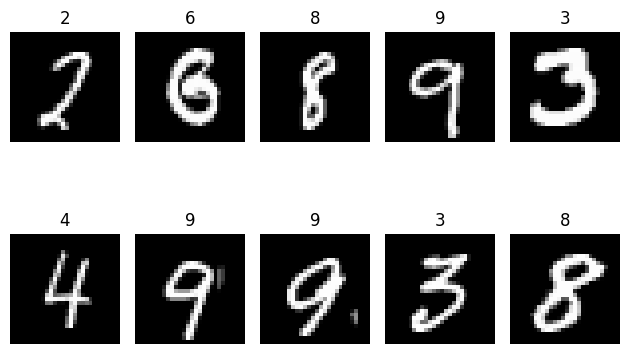

In [24]:
#학습데이터 랜덤으로 10장으로 확인
idxs = np.random.choice(len(train), size=10, replace=False)   # 전체 중 랜덤 10개 인덱스

plt.Figure(figsize=(10, 4))
for i, idx in enumerate(idxs):
    img, label = train[idx]                             # 랜덤 샘플(이미지 텐서, 라벨)
    plt.subplot(2, 5, i + 1)                            # 2행 5열
    plt.imshow(img.squeeze(0), cmap='gray')             # (1, 28, 28) -> (28, 28)
    plt.title(label)                                    
    plt.axis('off')                                     # 축 제거 
    
plt.tight_layout()                                      
plt.show()

plt.imshow() 로 받는 형태  
흑백 : (H, W)  
컬러 : (H, W, C)  
컬러 이미지의 경우 PyTorch 데이터셋이 (C, H, W) 형태라면 imshow()로 출력하기 위해서는 (H, W, C) 형태로 맞춰줘야 한다.  


img_hwc = img.permute(1, 2, 0)  # (C, H, W) -> (H, W, C)  
plt.imshow(img_hwc)

### NMIST 입력 / 정답 텐서 전처리 및 지원 확인

In [25]:
# 이미지 정규화 및 실수형 변환
x = train.data.float() / 255. # (0~255) ->  0~1로 스케일링
y = train.targets

print(x.size())

# 입력 텐서 형태 변환

x = x.view(x.size(0), -1)            # (N, 28, 28) -> (n, 784)로 펼쳐짐(flatten)

print(x.shape, y.shape)          # x: (N, 784), y : (샘플수 ,)



torch.Size([60000, 28, 28])
torch.Size([60000, 784]) torch.Size([60000])


In [26]:
# 입력/출력 차원 정의
input_size = x.size(-1)         # 입력 틍성 수(784)
output_size = int(max(y)) + 1   # 라벨 최대값 +1 = 클래스 갯수 10

print(f"input size {input_size}, output_size = {output_size}")


input size 784, output_size = 10


- 학습/검증/테스트 데이터셋 분리 및 정규화

In [27]:
# 학습/검증 데이터셋 비율 설정 및 계수 개산
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])               # 전체 샘플 중 학습 샘플 수 
vaild_cnt = int(x.size(0) * ratios[1])               # 전체 샘플 중 학습 샘플 수     
test_cnt = len(test.data)                            # 테스트 샘플 수
cnts = [train_cnt, vaild_cnt]                        # split에 사용할 [train, vaild] 

print(f"Train cnt = {train_cnt} , vaild_cnt = {vaild_cnt} ,test_cnt = {test_cnt} ")

Train cnt = 48000 , vaild_cnt = 12000 ,test_cnt = 10000 


In [28]:
# 학습/검증 데이터셋 무작d위셔틀 및 분할
indices = torch.randperm(x.size(0))                       # 0 ~ N-1 인덱스 랜덤 순서로 생성

x = torch.index_select(x, dim=0, index=indices)           # 랜덤 index 순서로 x를 재정렬
y = torch.index_select(y, dim=0, index=indices)           # 랜덤 index 순서로 y를 재정렬

x = list(x.split(cnts, dim=0))                            # x를 train/vaild 크기로 나눠 리스트로 반환
y = list(y.split(cnts, dim=0))                            # y를 train/vaild 크기로 나눠 리스트로 반환

print(x)

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])]


In [29]:
# 테스트데이터 정규화 및 추가

x += [(test.data.float() / 255.).view(test_cnt, -1)]        # 테스트 x를 0~1로 정규화 후 (N, 784)
y += [test.targets]                                         # y도 LIST에 추가

for x_i, y_i in zip(x, y):                                  # (train, vaild, test) 순서로 순회
    print(x_i.size(), y_i.size())                           # 각 데이터셋의 입력/라벨 텐서 크기 출력

torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [30]:
class Block(nn.Module):
    
    # 입력 -> 선형변환 -> 활성화 -> (BatchNorm or Dropout)으로 구성된 블록을 초기화하는 생성자
    def __init__(self, input_size, output_size, use_batch_norm=True, dropout_p=.4):
        self.input_size = input_size                        # 입력 차원 저장
        self.output_size = output_size                      # 출력 차원 저장
        self.use_batch_norm = use_batch_norm                # BN 사용 여부 저장
        self.dropout_p = dropout_p                          # Dropout 비율 저장
            
        super().__init__()                                  # nn.Module 초기화
        
        #BN을 사용할지 , Dropout을 사용할지 선택해서 정규화 모듈을 반환하는 함수
        def get_regularizer(use_batch_norm, size):
            return nn.BatchNorm1d(size) if use_batch_norm else nn.Dropout(dropout_p)     # BN 또는 Dropout 선택
        
        self.block = nn.Sequential(                                 # 레이어들을 순서대로 묶어 하나의 블록으로 구성
            nn.Linear(input_size, output_size),                     # input_size -> output_size 선정 변환
            nn.LeakyReLU(),                                         # 음수 영역도 기울기 유지하는 활성화 함수
            get_regularizer(use_batch_norm, output_size)            # BatchNormid(output_size) 또는 Dropout(dropout_p) 
        )
    
    # 입력 x를 block을 통과시켜 출력 y를 만드는 순전파    
    def forward(self, x):
        # |x| = (batch_size, input_size)    # 텐서의 모양 약속/설명
        y = self.block(x)                   # Linear -> LeakyRELU -> (BN/Dropout) 적용
        # |y| = (batch_size, output_size)   # 텐서의 모양 약속/설명
        return y

In [31]:
class MyModel(nn.Module):
    # 여러 개의 Block을 쌓아 분류용 MLP(출력층 LogSoftmax 활성화함수)를 구성한다
    def __init__(self, input_size, output_size, use_batch_norm=True, dropout_p=.4):
        super().__init__()                                                         # nn.Module 초기화

        self.layers = nn.Sequential(                                               # 레이어들을 순서대로 묶어 모델 구성
            Block(input_size, 500, use_batch_norm, dropout_p),                     # 입력 차원 -> 500 차원 블록
            Block(500, 400, use_batch_norm, dropout_p),                            # 500 -> 400 차원(노드) 블록
            Block(400, 300, use_batch_norm, dropout_p),                            # 400 -> 300 차원(노드) 블록
            Block(300, 200, use_batch_norm, dropout_p),                            # 300 -> 200 차원(노드) 블록
            Block(200, 100, use_batch_norm, dropout_p),                            # 200 -> 100 차원(노드) 블록
            nn.Linear(100, output_size),                                           # 마지막 은닉(100) -> 출력(output_size) 선형 변환
            nn.LogSoftmax(dim=1)                                                   # 클래스 차원(dim-1) 기준 log-확률로 변환
        )
    
    # 입력 x를 순차 레이어(self, layers)에 통과 시켜 최종 출력 y를 만드는 순전파
    def forward(self, x):
        # |x| = (batch_size, input_size)    # 텐서의 모양 약속/설명
        y = self.layers(x)                  # Block들 -> Linear -> logSoftmax 순서로 통과
        # |y| = (batch_size, output_size)   # 텐서의 모양 약속/설명
        return y # 각 클래스별 log-확률로 변환
        
      

In [32]:
model = MyModel(
    input_size,             # 입력 벡터 차원(784)
    output_size,            # 출력 벡터 차원 (10)
    use_batch_norm=True     # 각 Block에서 batchNorm 사용 (Dropout은 사용하지 않음)
)

model

MyModel(
  (layers): Sequential(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=784, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=500, out_features=400, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Block(
      (block): Sequential(
        (0): Linear(in_features=400, out_features=300, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Block(
      (block): Sequential(
        (0): Linear(in_features=300, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(200, e

In [33]:
# 손실함수 : MLLoss (음의 로그 우도 손실) = LogSoftmax 출력(log - 확률) 과 함께 사용한다.
crit =  nn.NLLLoss()

In [34]:
optimizer = optim.Adam(         # lr 기본값 0.001 사용한 Adam Optimizer
    model.parameters()          # 학습 대상 파라미터 (가중치 / 편향)
    ) 

In [35]:
# 만약 GPU 사용가능시 "cuda"로, 불가 시 "cpu" (삼향연산자)
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

In [36]:
# 모델과 데이터셋을 선택된 장치 (GPU or CPU)로 이동시키기
model = model.to(device)    # 모델 파라미터를 device(cuda/cpu)로 이동 

x = [ x_i.to(device) for x_i in x]  # (train/vaild/test) 입력 텐서들을 device로 이동
y = [ y_i.to(device) for y_i in y]  # (train/vaild/test) 라벨 텐서들을 device로 이동

In [37]:
# 학습 하이퍼파라미터 설정
n_epochs = 1000         # 학습 반복 
batch_size = 256        # 미니배치 크기 (한번에 학습할 샘플 수)
print_interval = 20     # 로그 출력 주기

In [38]:
# Early Stopping 설정
from copy import deepcopy       # 객체(모델 파라미터) 복사 유틸

lowest_loss = np.inf            # 검증 손실 최소값
best_model = None               # 최고 선능 모델 

early_stop = 50                 # 개션이 없을 시 중단할 patience (기다림 횟수)
lowest_epoch = np.inf           # 최솟값 갱신된 epoch

In [39]:
y[0].size()

torch.Size([48000])

In [ ]:
# 학습 루프 + 검증 + Early Stopping

# 손실 기록 리스트 초기화
train_history, valid_history = [], []   # epoch별 train / valid loss 저장 리스트

# 에폭 반복 
for i in range(n_epochs):
    model.train()           # 학습 모드 (Dropout/BN 등 활성화)

    # 학습 데이터 셔플 및 미니배치 분할
    indices = torch.randperm(x[0].size(0)).to(device)           # 학습 데이터 인덱스 램덤 셔플
    x_ = torch.index_select(x[0], dim = 0, index = indices)     # 셔플된 순서로 train x 재정렬
    y_ = torch.index_select(y[0], dim = 0, index = indices)     # 셔플된 순서로 train y 재정렬

    x_ = x_.split(batch_size, dim = 0 )         # 미니배치 단위로 분할(튜플 반환)
    y_ = y_.split(batch_size, dim = 0 )         # 미니배치 단위로 분할(튜플 반환)

    train_loss, valid_loss = 0, 0               # epoch 누적 손실 평균
    y_hat = []                                  # 검증 예측값 저장

    # 미니배치 단위로 학습
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)                    # 순전파 : logits 계산
        loss = crit(y_hat_i, y_i.squeeze())     # 손실 계산 (shpae은 (N, ) 형태로 변환)

        optimizer.zero_grad()                   # 이전 배치 기울기 초기화 
        loss.backward()                         # 역전파 : 기울기 계산

        optimizer.step()                        # 파라미터 업데이트
        train_loss += float(loss)               # 텐서 -> 파이썬 Float 로 누적(그래프 참조 방지)

    # 손실 평균
    train_loss = train_loss / len(x_)           # 미니 배치 평균 train_loss 계산

    # 검증
    model.eval()                                # 퍙가 모드 (Dropout 비활성화, BN 고정)
    with torch.no_grad():                       # 검증은 기울기 계산 생략
        x_ = x[1].split(batch_size, dim = 0)    # valid x를 미니배치 단위로 분할
        y_ = y[1].split(batch_size, dim = 0)    # valid y를 미니배치 단위로 분할

        valid_loss = 0                          # valid loss 누적값 초기화

        # 검증 손실 계산
        for x_i, y_i in zip(x_, y_):            
            y_hat_i = model(x_i)                    # 순전파 : 예측 계산
            loss = crit(y_hat_i, y_i.squeeze())     # 손실 계산

            valid_loss += float(loss)               # 텐서 -> 숫자로 누적 

            y_hat += [y_hat_i]                      # 예측값 저장


    # 손실 평균 및 기록
    valid_loss = valid_loss / len(x_)       # 미니배치 평균으로 valid_loss 계산

    train_history += [train_loss]   # train_loss 저장
    valid_history += [valid_loss]   # valid_loss 저장

    # 일정 간격마다 로그 출력
    if (i + 1) % print_interval  == 0:
        print(f"Epoch {i + 1}, train_loss = {train_loss:.4e}, valid_loss = {valid_loss:.4e}, lowest_loss = {lowest_loss:.4e}")

    # Early Stopping
    if valid_loss <= lowest_loss:       # valid_loss 가 개선이 되면
        lowest_loss = valid_loss        # 최저 손실 갱신
        lowest_epoch = i + 1            # 현재 epoch 기록

        best_model = deepcopy(model.state_dict())   # 현재 모델 가중치 스냅샷 저장
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1 :       # patience 초과 여부 확인
            print(f" {early_stop} 에포크만큼 진행되었으나 더이상 항상되지 않음")
            break

print(f"가장 손실이 낮은 에포크 : {lowest_epoch + 1}, 이 때 최소 손실값은 : {lowest_loss}")

# 최적의 모델 복원
model.load_state_dict(best_model)       # 저장해둔 best weight로 모델 복원 

/var/folders/g7/6_f4vlmd2tnf4ghbk1n9tv_40000gn/T/ipykernel_46630/2543644782.py:30: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:837.)
  train_loss += float(loss)               # 텐서 -> 파이썬 Float 로 누적(그래프 참조 방지)


Epoch 20, train_loss = 9.1303e-03, valid_loss = 7.3339e-02, lowest_loss = 6.4879e-02
Epoch 40, train_loss = 5.1641e-03, valid_loss = 8.7123e-02, lowest_loss = 6.4879e-02
Epoch 60, train_loss = 2.7160e-03, valid_loss = 8.6831e-02, lowest_loss = 6.4879e-02
 50 에포크만큼 진행되었으나 더이상 항상되지 않음
가장 손실이 낮은 에포크 : 14, 이 때 최소 손실값은 : 0.06487947776715489


<All keys matched successfully>

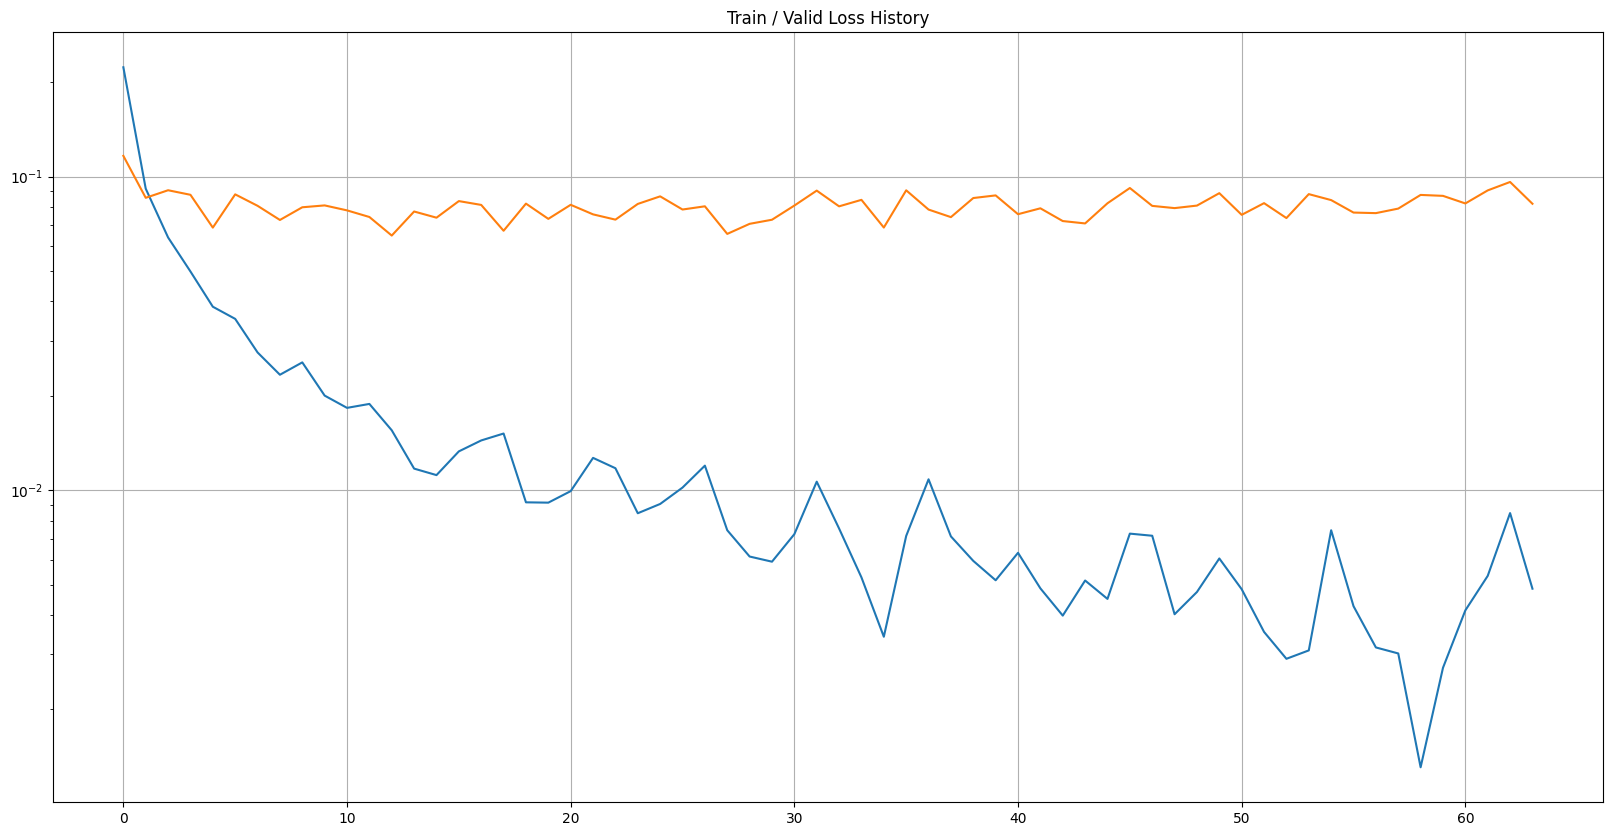

In [41]:
# 학습/검증 손실 이력 시각화
plot_from = 0   # 손실 그래프 그릴 시작 epoch

plt.figure(figsize=(20,10))
plt.grid(True)                              # 격자 표시 (가독성)
plt.title("Train / Valid Loss History")     
plt.plot(
    range(plot_from, len(train_history)),   # train x 축 (epoch 인덱스)
    train_history[plot_from:],              # train y 축 (loss)
    range(plot_from, len(valid_history)),   # valid x 축 (epoch 인덱스)
    valid_history[plot_from:],              # valid y 축 (Loss)
)
plt.yscale('log')   # y축은 로그스케일 적용 ( 손실 변화를 보기 쉽게 만듬 )
plt.show()


# 테스트 데이터 평가

In [ ]:
# 테스트 손실 초기화 및 예측값 저장 리스트
test_loss = 0 
y_hat = []

# 검증
model.eval()                                # 퍙가 모드 (Dropout 비활성화, BN 고정)
with torch.no_grad():                       # 검증은 기울기 계산 생략
    x_ = x[-1].split(batch_size, dim = 0)    # test x를 미니배치 단위로 분할
    y_ = y[-1].split(batch_size, dim = 0)    # test y를 미니배치 단위로 분할


    # 배치 단위 평가 수행
    for x_i, y_i in zip(x_, y_):            
        y_hat_i = model(x_i)                    # 순전파 : 예측 계산
        loss = crit(y_hat_i, y_i.squeeze())     # 손실 계산

        test_loss += float(loss)               # 텐서 -> 숫자로 누적 

        y_hat += [y_hat_i]                      # 예측값 저장


# 손실 평균 및 기록
test_loss = test_loss / len(x_)       # 미니배치 평균으로 test_loss 계산
y_hat = torch.cat(y_hat, dim = 0)     # 배치 예측들을 (N,opuput_size)로 합침

# 테스트 결과 출력
print(f"Test loss = {test_loss:.4e}")

Test loss = 6.3443e-02


In [44]:
# 테스트 데이터 정확도 계산 
# 예측 클래스(argmax) 의 정답 라벨이 같은 개수를 합산
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim = -1)).sum()
total_cnt = float(y[-1].size(0))    # 전체 데이터 샘플 수

print(f"Accuracy : {correct_cnt / total_cnt:.4f}")

Accuracy : 0.9821


In [46]:
pd.DataFrame(
    confusion_matrix(
        y[-1].cpu().numpy(),        # 정답라벨 CPU로 옮겨 numpy()로 변환
        torch.argmax(y_hat, dim = -1 ).cpu().numpy()    # 예측 확률에서 argmax로 클래스 선택 후 numpy 변환
    ),
    index = [f'true_{i}' for i in range(10)],        # 행 이름 : 실제 클래스 (0~9)
    columns = [f'pred_{i}' for i in range(10)]      # 열 이름 : 예측 클래스 (0~9)
)

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,972,0,0,0,0,1,0,1,3,3
true_1,1,1128,1,0,0,0,1,2,2,0
true_2,5,0,1017,1,1,1,2,3,2,0
true_3,0,0,2,991,0,8,0,3,5,1
true_4,1,1,3,1,959,0,3,2,0,12
true_5,2,1,0,7,3,863,7,1,7,1
true_6,3,2,1,1,2,4,944,0,1,0
true_7,0,3,13,2,0,0,0,1003,2,5
true_8,1,0,2,0,3,3,1,3,958,3
true_9,5,1,0,5,8,2,0,1,1,986


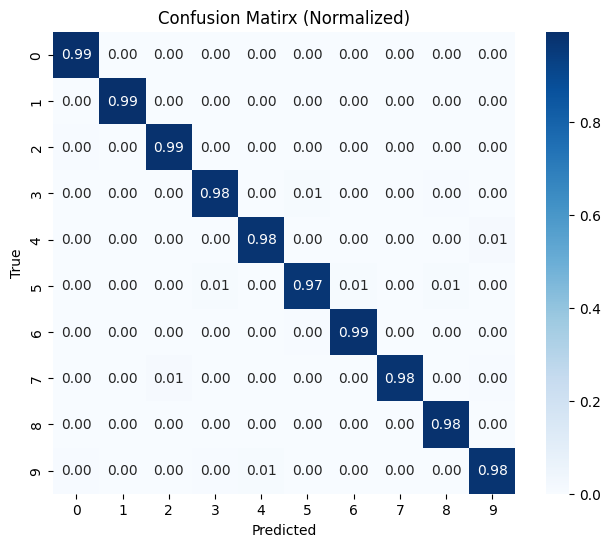

In [48]:
cm = confusion_matrix(
    y[-1].cpu().numpy(),        # 정답라벨 CPU로 옮겨 numpy()로 변환
    torch.argmax(y_hat, dim = -1 ).cpu().numpy()    # 예측 확률에서 argmax로 클래스 선택 후 numpy 변환
)

cm_norm = cm / cm.sum(axis = 1, keepdims = True)    # 행(정답 클래스)별 합으로 나눠 비율(0~1)로 정규화

plt.figure(figsize = (8, 6))
sns.heatmap(
    cm_norm,            # 표시할 데이터
    annot = True,       # 각 셀에 값(숫자) 표시
    fmt = '.2f',        # 셀에 표시할 숫자 포맷
    cmap = 'Blues',     # 컬러맵
    square = True       # 각 셇을 정사각형 비율로 맞춤
    )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matirx (Normalized)")
plt.show()